# Logistic regression implementation
- workhorse of ML
- before deep learning era, LogReg(Logistic Regression) was the default choice
- works in binary, multi class and multi-label calssification set ups

In [1]:
#@title [Import Libraries]
from IPython.display import display, Math, Latex

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
np.random.seed(1234)

# Implementation
implement individual components of binary logistic regression one by one

## Model

In [3]:
def linear_combination(X,w):
  return X@w

In [4]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

In [5]:
def predict(X,w,threshold):
  return np.where(sigmoid(linear_combination(X,w))>threshold,1,0)

In [6]:
feature_matrix= np.array([[1,20,2],[1,2,2]])
weight_vector=np.array([-1,0,1])
print("shape of feature matrix", feature_matrix.shape)
print("shape of weight vector", weight_vector.shape)

class_labels=predict(feature_matrix, weight_vector,0.5)
print("shape of output is:", class_labels.shape)
print("The class label vector is: ", class_labels)

shape of feature matrix (2, 3)
shape of weight vector (3,)
shape of output is: (2,)
The class label vector is:  [1 1]


## Loss function

$$e = ylog(sigmoid(X\mathbf{w}))+(1-y)log(1-sigmoid(Xw))$$
$$J(\mathbf{w}) = -1_{1xn}^Te_{nx1}$$
Adding $L_2$ penalty we get:
$$J(\mathbf{w}) = -1^Te+\lambda \mathbf{w}^T\mathbf{w}$$
Adding $L_1$ penalty we get:
$$J(\mathbf{w}) = -1^Te+\lambda |\mathbf{w}|$$

In [7]:
def loss(y, sigmoid_vector, weight_vector, l1_reg_rate, l2_reg_rate):
  return (-1*(np.sum(y*np.log(sigmoid_vector)+(1-y)*np.log(1-sigmoid_vector))))
  +l2_reg_rate*np.dot(np.transpose(weight_vector),weight_vector)
  +l1_reg_rate*np.sum(np.abs(weight_vector))

In [52]:
y=np.array([ 1, 0, 0, 1, 0, 0, 0, 1, 1 ])
sigmoid_vector = np.array([0.9,0.3,0.25,0.88,0.1,0.1,0.6,0.9,0.75])

In [53]:
def loss2(y, sigmoid_vector):
  return (-1*(np.sum(y*np.log(sigmoid_vector)+(1-y)*np.log(1-sigmoid_vector))))
loss2(y, sigmoid_vector)

2.397605254857639

## Optimization

### Gradient of loss function

$$\frac{\partial}{\partial \mathbf{w}}J(\mathbf{w}) = X^T(sigmoid(X\mathbf{w})-\mathbf{y})+\lambda \mathbf{w}$$

In [8]:
def calculate_gradient(X,y,w,reg_rate):
  return np.transpose(X)@(sigmoid(linear_combination(X,w))-y)+reg_rate*w

## Logistic regression class implementation

In [9]:
class LogisticRegression(object):
  """
  y = sigmoid(X@w)
  """

  def set_weight_vector(self,w):
    self.w=w

  def linear_combination(self,X):
    return X@self.w

  def sigmoid(self,z):
    return 1/(1+np.exp(-z))

  def activation(self,X):
    return self.sigmoid(self.linear_combination(X))

  def predict(self,x,threshold=0.5):
    """Classify input data
    """
    return (self.activation(x)>threshold).astype(int)

  def loss(self, X,y,reg_rate):
    predicted_prob = self.activation(X)
    return (-1*(np.sum(y*np.log(predicted_prob)+(1-y)*np.log(1-predicted_prob)))
            +reg_rate*np.dot(np.transpose(self.w),self.w))
  
  def calculate_gradient(self,X,y, reg_rate):
    return np.transpose(X)@(self.activation(X)-y)+reg_rate*self.w
  
  def update_weight(self,grad,lr):
    return (self.w-lr*grad)

  def gd(self,X,y,num_epochs,lr, reg_rate):
    self.w = np.zeros(X.shape[1])
    self.w_all=[]
    self.err_all = []
    for i in np.arange(0,num_epochs):
      dJdW = self.calculate_gradient(X,y,reg_rate)
      self.w_all.append(self.w)
      self.err_all.append(self.loss(X,y,reg_rate))
      self.w= self.update_weight(dJdW,lr)
    return self.w

  

  

# Demonstration

## Demo-1: Logistic Regression for linearly sepeabrable binary classification

STEP-1: Creating toy dataset

In [10]:
#@title [Toy dataset creation]
def create_toy_data():
  x0= np.random.normal(size=50).reshape(-1,2)-1
  x1 = np.random.normal(size=50).reshape(-1,2)+1
  return np.concatenate([x0,x1]), np.concatenate([np.zeros(25),np.ones(25)]).astype(np.int)

In [11]:
feature_matrix, label_vector = create_toy_data()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [12]:
feature_matrix.shape

(50, 2)

In [13]:
label_vector.shape

(50,)

In [14]:
assert feature_matrix.shape[0]== label_vector.shape[0]

STEP-2: Adding dummy feature to the feature matrix. Use polynomial transformation of degree=1 to add it.

In [15]:
#@title [Polynomial transformation]
import itertools
import functools

def get_combinations(x, degree):
  return itertools.combinations_with_replacement(x,degree)

def compute_new_feature(items):
  #reduce(lambda x,y:x*y, [1,2,3,4,5]) calculates ((((1*2)*3)*4)*5)
  return functools.reduce(lambda x, y:x*y,items)
  
#Implementation adopted from (https://github.com/ctgk/PRML/blob/master/prml/preprocess/polynomial.py)
def polynomial_transform(x, degree,logging=False):
  #Converts to feature matrix
  if x.ndim==1:
    x=x[:,None]
  x_t = x.transpose() #Transpose the feature matrix
  features = [np.ones(len(x))] #Populates 1s as first feature of each example
  print('feature-initial',features)
  if logging:
    print("Input:",x)
  for degree in range(1,degree+1):
    for items in get_combinations(x_t,degree): #generate combinations
      features.append(compute_new_feature(items))
      if logging:
        print(items,":",compute_new_feature(items))
  if logging:
    print(np.asarray(features).transpose())
  return np.asarray(features).transpose()

In [16]:
feature_matrix_bias = polynomial_transform(feature_matrix,degree=1)

feature-initial [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]


Splitting into training and test data sets

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature_matrix_bias, label_vector)

STEP-4: visualize the training data

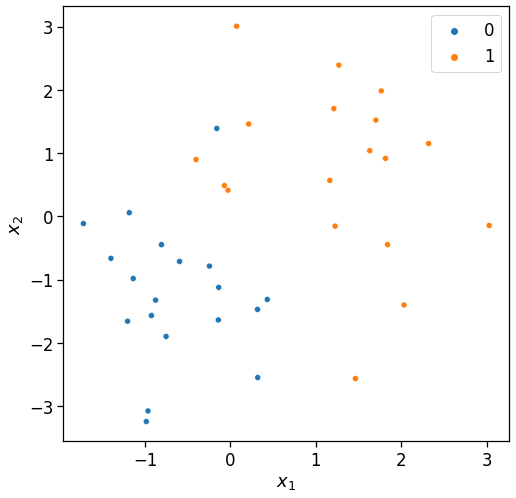

In [18]:
#@title [visualize Training set]
f=plt.figure(figsize=(8,8))
sns.set_context("notebook", font_scale=1.5, rc={"linewidth":2.5})

sns.scatterplot(data=x_train,x=x_train[:,-2],y=x_train[:,-1],hue=y_train)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

STEP-5: Instantiate and Train the model

In [19]:
log_reg = LogisticRegression()
log_reg.gd(x_train, y_train, num_epochs=1000, reg_rate=0, lr=1e-2)

array([-0.14559758,  4.43289743,  1.94514132])

In [20]:
#@title [Learning Curves]
def plot_learning_curve(err):
  plt.plot(np.arange(len(err)),err,'r-')
  plt.xlabel('Iter #')
  plt.ylabel('$\mathbf{J(w)}$')

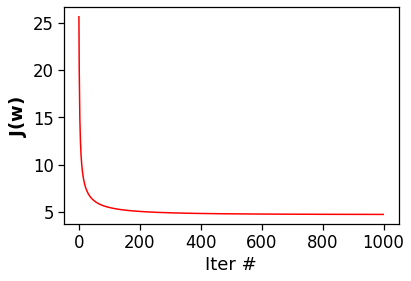

In [21]:
plot_learning_curve(log_reg.err_all)

In [22]:
print("Weight vector", log_reg.w)

Weight vector [-0.14559758  4.43289743  1.94514132]


In [23]:
#@title [Model visualization]
sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth":2.5})

def visualize_model(x_train, labels, lsc_obj, degree=1):
  f=plt.figure(figsize=(8,8))

  #compute xlim and ylim
  x1_min = np.min(x_train[:,1])
  x1_max = np.max(x_train[:,1])
  x2_min = np.min(x_train[:,2])
  x2_max = np.max(x_train[:,2])

  x1_test, x2_test, =np.meshgrid(np.linspace(x1_min, x1_max,100), np.linspace(x2_min,x2_max,100))
  x_test =np.array([x1_test,x2_test]).reshape(2,-1).T
  x_test_poly = polynomial_transform(x_test,degree=degree)
  y_test = lsc_obj.predict(x_test_poly)

  sns.scatterplot(data=x_train,x=x_train[:,1], y=x_train[:,2],hue=labels)
  plt.contourf(x1_test,x2_test,y_test.reshape(100,100),alpha=0.5,levels=np.linspace(0,1,3))
  plt.xlabel("$x_1$")
  plt.ylabel("$x_2$")
  plt.xlim(x1_min,x1_max)
  plt.ylim(x2_min,x2_max)
  plt.gca().set_aspect('equal',adjustable='box')
  plt.show()

feature-initial [array([1., 1., 1., ..., 1., 1., 1.])]


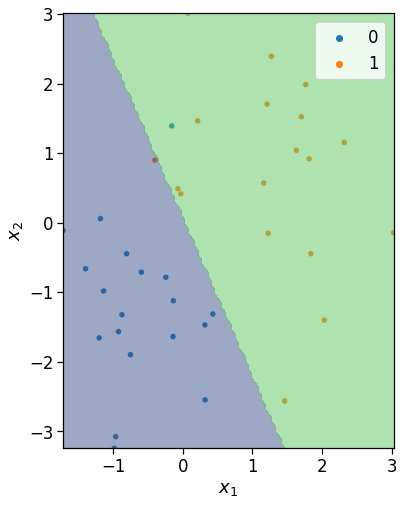

In [24]:
visualize_model(x_train, y_train, log_reg)

STEP-6: Model Evaluation

In [25]:
y_test_hat = log_reg.predict(x_test)

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_test_hat,zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.78      1.00      0.88         7

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13



## Demo-2: Polynomial least square classification

STEP-1: circular decision boundary

In [27]:
from sklearn.datasets import make_circles
feature_matrix, label_vector = make_circles()

In [28]:
assert feature_matrix.shape[0]== label_vector.shape[0]

STEP-2: polynomial feature transformation

In [29]:
x_poly = polynomial_transform(feature_matrix, degree=2)

feature-initial [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]


In [30]:
feature_matrix.shape[1]

2

In [31]:
x_poly.shape[1]

6

Four additional features:
1. Dummy feaure
2. Squares of original feature
3. One for feature of product of two feature

In [32]:
feature_matrix[:5]

array([[-8.00000000e-01, -2.57299624e-16],
       [-1.49905052e-01,  7.85829801e-01],
       [-5.09939192e-01,  6.16410594e-01],
       [-7.93691761e-01, -1.00266587e-01],
       [ 3.40623433e-01, -7.23861642e-01]])

STEP-3: split training and test

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_poly, label_vector)

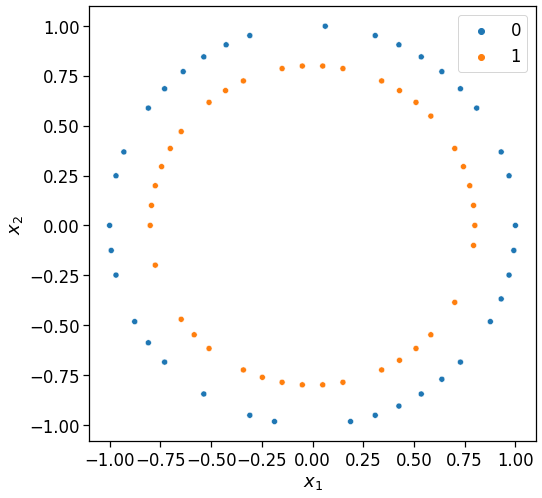

In [34]:
#@title [visualize Training set]
f=plt.figure(figsize=(8,8))
sns.set_context("notebook", font_scale=1.5, rc={"linewidth":2.5})

sns.scatterplot(data=x_train,x=x_train[:,1],y=x_train[:,2],hue=y_train)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [35]:
log_reg_poly = LogisticRegression()
log_reg_poly.gd(x_train,y_train, reg_rate=0, num_epochs=1000,lr=1e-2)

array([ 9.42835919e+00, -4.03935783e-02,  8.14414670e-03, -1.16783887e+01,
        1.19896616e-01, -1.14288047e+01])

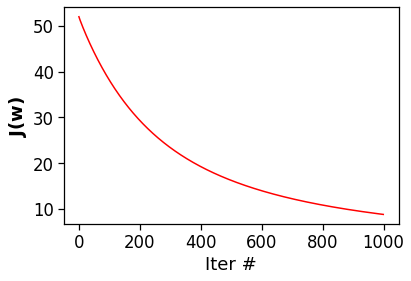

In [36]:
plot_learning_curve(log_reg_poly.err_all)

feature-initial [array([1., 1., 1., ..., 1., 1., 1.])]


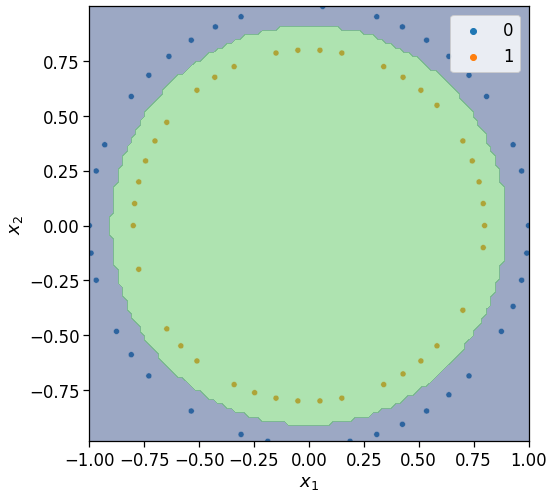

In [37]:
visualize_model(x_train, y_train, log_reg_poly, degree=2)

In [38]:
y_test_hat=log_reg_poly.predict(x_test)

In [39]:
print(classification_report(y_test,y_test_hat,zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



# Logistic regression visualization

## Loss surface
1. Generate a grid of weights- $w_1$ and $w_2$
2. For each point on grid, claculate cross entropy loss on the fix training set
3. Plot contour of weights and loss

In [40]:
from matplotlib import cm
from matplotlib.colors import colorConverter, ListedColormap

In [41]:
log_reg_vis = LogisticRegression()

In [42]:
feature_matrix, label_vector = create_toy_data()
feature_matrix_bias = polynomial_transform(feature_matrix, degree=1)
x_train, x_test, y_train, y_test = train_test_split(feature_matrix_bias, label_vector)

feature-initial [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [43]:
x_train.shape

(37, 3)

generate grid of weights

In [44]:
point_count=25
w1 = np.linspace(-5,5, num=point_count)
w2 = np.linspace(-5,5,num=point_count)
w1_list, w2_list = np.meshgrid(w1,w2) #generate grid

In [45]:
loss = np.zeros((point_count, point_count)) #initialize loss matrix

#Fill the loss matrix for each combination of weights
for i in range(point_count):
  for j in range(point_count):
    weight_vector = np.array([0,w1_list[i,j], w2_list[i,j]])
    log_reg_vis.set_weight_vector(weight_vector)
    loss[i,j] = log_reg_vis.loss(x_train, y_train, reg_rate=0)

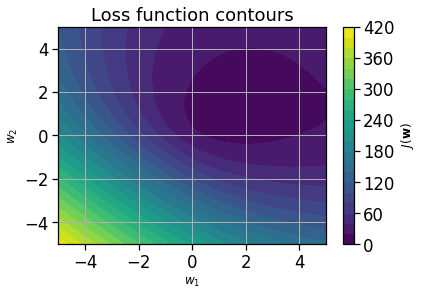

In [46]:
plt.figure(figsize=(6,4))
plt.contourf(w1_list, w2_list,loss, 20, cmap=cm.viridis)
cbar= plt.colorbar()
cbar.ax.set_ylabel('$J(\mathbf{w})$', fontsize=12)
plt.xlabel('$w_1$', fontsize=12)
plt.ylabel('$w_2$', fontsize=12)
plt.title('Loss function contours')
plt.grid()
plt.show()


## Gradient descent trajectory

In [47]:
log_reg_vis.gd(x_train, y_train, num_epochs=1000, reg_rate=0, lr=1e-2)

array([0.6958067 , 1.61362475, 0.87521977])

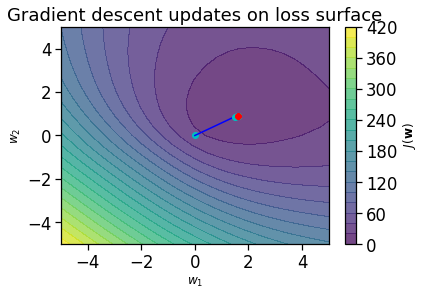

In [48]:
plt.figure(figsize=(6,4))
plt.contourf(w1_list, w2_list,loss, 20,alpha=0.75, cmap=cm.viridis)
cbar= plt.colorbar()
cbar.ax.set_ylabel('$J(\mathbf{w})$', fontsize=12)

#Plot weights after each few epochs
for i in range(1,900,100):
  w1 = log_reg_vis.w_all[(i-1)]
  w2 = log_reg_vis.w_all[(i+100)]

  #Plot the weight-loss values that represents the update
  plt.plot(w1[1],w1[2], marker='o', color='c') #Plot the weight loss value
  plt.plot([w1[1],w2[1]],[w1[2],w2[2]],linestyle='-',color='b')

#Plot the last weight
w1 = log_reg_vis.w_all[-1]
plt.plot(w1[1],w1[2], marker='o', color='r')

#Show the figure
plt.xlabel('$w_1$', fontsize=12)
plt.ylabel('$w_2$', fontsize=12)
plt.title('Gradient descent updates on loss surface')
plt.show()

# Graded Assignment

In [49]:
def gradient(X,y,w,reg_rate):
  G= np.transpose(X)@(sigmoid(X@w)-y)+reg_rate*w
  return G

In [50]:
gradient(np.array([[1,2],[1,3]]),np.array([1,0]),np.array([0.1,0.2]),0)

array([0.2906471 , 1.24948198])